In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install unrar

In [3]:
import os
os.makedirs('data', exist_ok=True)

In [4]:
# En tu Drive de Google tenés que crear la siguiente estructura de carpetas /IADesafio02/data/comprimidos/ y subir el rar que podés descargar desde:
# ....

In [4]:
!unrar x '/content/drive/MyDrive/Colab Notebooks/data/comprimidos/images_binario_224.rar' './data'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Extracting  ./data/images_binario_224/40619_right.jpeg                    72%  OK 
Extracting  ./data/images_binario_224/40622_left.jpeg                     72%  OK 
Extracting  ./data/images_binario_224/40622_right.jpeg                    72%  OK 
Extracting  ./data/images_binario_224/40624_left.jpeg                     72%  OK 
Extracting  ./data/images_binario_224/40624_right.jpeg                    72%  OK 
Extracting  ./data/images_binario_224/40630_left.jpeg                     72%  OK 
Extracting  ./data/images_binario_224/40630_right.jpeg                    72%  OK 
Extracting  ./data/images_binario_224/40631_left.jpeg                     72%  OK 
Extracting  ./data/images_binario_224/40631_right.jpeg                    72%  OK 
Extracting  ./data/images_binario_224/40638_left.jpeg                     72%  OK 
Extracting  .

In [ ]:
# En tu Drive de Google tenés que crear la siguiente estructura de carpetas /IADesafio02/data y subir el siguiente CSV: 
....

In [59]:
data_dir = './data/images_binario_224'
drive_dir = '/content/drive/MyDrive/Colab Notebooks/data/comprimidos'

In [60]:
res_x = 224
res_y = 224

In [61]:
import os, shutil
import pandas as pd

In [62]:
df = pd.read_csv(drive_dir + '/images_binario_224.csv')

In [63]:
df['image'] = df['image'] + '.jpeg'

In [64]:
df['image'].head()

0        10_left.jpeg
1       10_right.jpeg
2     10003_left.jpeg
3    10003_right.jpeg
4     10013_left.jpeg
Name: image, dtype: object

In [65]:
df.shape

(18632, 6)

In [66]:
(X, y) = (df['image'], df['Diabetes'])
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, stratify=y, test_size=0.2, random_state=42)

In [67]:
test, val = train_test_split(val, stratify=val['Diabetes'], test_size=0.5, random_state=42)

In [68]:
train['Diabetes'].value_counts()

Si    7453
No    7452
Name: Diabetes, dtype: int64

In [69]:
test['Diabetes'].value_counts()

No    932
Si    931
Name: Diabetes, dtype: int64

In [70]:
val['Diabetes'].value_counts()

Si    932
No    932
Name: Diabetes, dtype: int64

In [71]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(res_x, res_y, 3))

In [72]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable

In [73]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [74]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          147488    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 14,866,337
Trainable params: 7,231,073
Non-trainable params: 7,635,264
___________________________________

In [75]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train, # Referimos el df de train
    directory=data_dir, # El directorio donde se encuentran las imágenes
    x_col='image', # La columna con los path de los archivos
    y_col='Diabetes', # La variable con las labels
    target_size=(res_x, res_y),
    classes=None, # Las clases se obtienen a partir de y_col
    class_mode='binary', # Se trata de un problema multi-class, multi-label
    batch_size=200
   )

validation_generator = val_datagen.flow_from_dataframe(
    val, # Referimos el df de validación
    directory=data_dir, # El directorio donde se encuentran las imágenes
    x_col='image', # La columna con los path de los archivos
    y_col='Diabetes', # La variable con las labels
    target_size=(res_x, res_y),
    classes=None, # Las clases se obtienen a partir de y_col
    class_mode='binary', # Se trata de un problema multi-class, multi-label
    batch_size=200,
    shuffle=False
   )

Found 14905 validated image filenames belonging to 2 classes.
Found 1864 validated image filenames belonging to 2 classes.


In [76]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adagrad(
                learning_rate=0.001,
                initial_accumulator_value=0.1,
                epsilon=1e-07),
              metrics=['accuracy'])

In [77]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

h5dir = '/content/drive/MyDrive/Colab Notebooks/data/diabetes09B_VGG16'
os.makedirs(h5dir, exist_ok=True)
checkpoint = ModelCheckpoint(h5dir + '/weights.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=0,
                             save_best_only=True, save_weights_only=False, mode='auto')

# No se utilizan pero se dejan instanciados por si se quieren utilizar en alguna prueba
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

callbacks_list = [checkpoint]

In [78]:
history = model.fit(
      train_generator,
      steps_per_epoch=30,
      epochs=200,
      validation_data=validation_generator,
      validation_steps=5,
      verbose=1,
      callbacks=callbacks_list)

Epoch 1/200
30/30 [==============================] - 16s 543ms/step - loss: 0.6765 - accuracy: 0.5832 - val_loss: 0.6487 - val_accuracy: 0.6630
Epoch 2/200
30/30 [==============================] - 16s 524ms/step - loss: 0.6499 - accuracy: 0.6293 - val_loss: 0.6294 - val_accuracy: 0.6630
Epoch 3/200
30/30 [==============================] - 16s 518ms/step - loss: 0.6376 - accuracy: 0.6347 - val_loss: 0.6174 - val_accuracy: 0.6700
Epoch 4/200
30/30 [==============================] - 16s 518ms/step - loss: 0.6303 - accuracy: 0.6412 - val_loss: 0.6058 - val_accuracy: 0.6810
Epoch 5/200
30/30 [==============================] - 15s 516ms/step - loss: 0.6183 - accuracy: 0.6510 - val_loss: 0.6181 - val_accuracy: 0.6700
Epoch 6/200
30/30 [==============================] - 15s 516ms/step - loss: 0.6127 - accuracy: 0.6542 - val_loss: 0.5921 - val_accuracy: 0.6930
Epoch 7/200
30/30 [==============================] - 16s 518ms/step - loss: 0.6119 - accuracy: 0.6591 - val_loss: 0.5853 - val_accuracy:

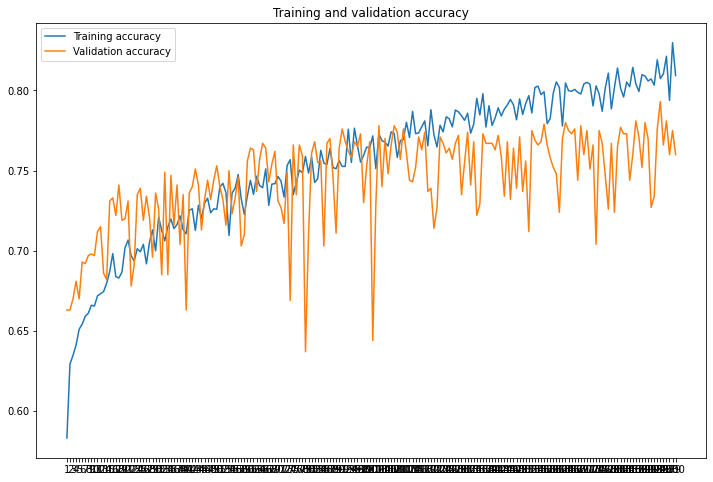

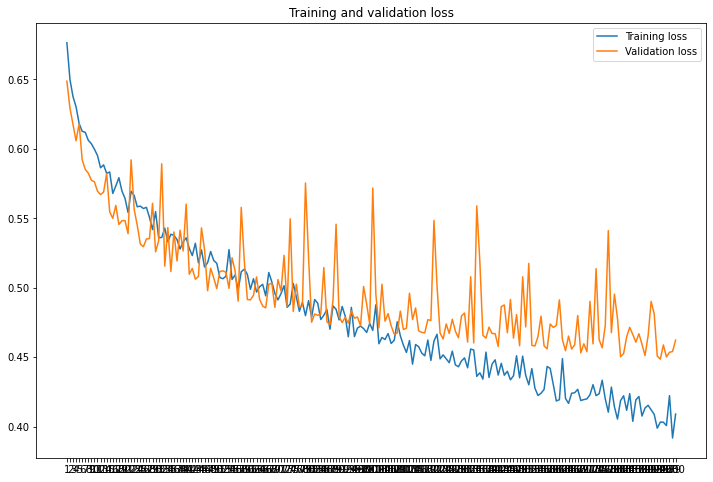

In [82]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xticks(ticks=epochs)
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xticks(ticks=epochs)
plt.title('Training and validation loss')
plt.legend()
plt.show()

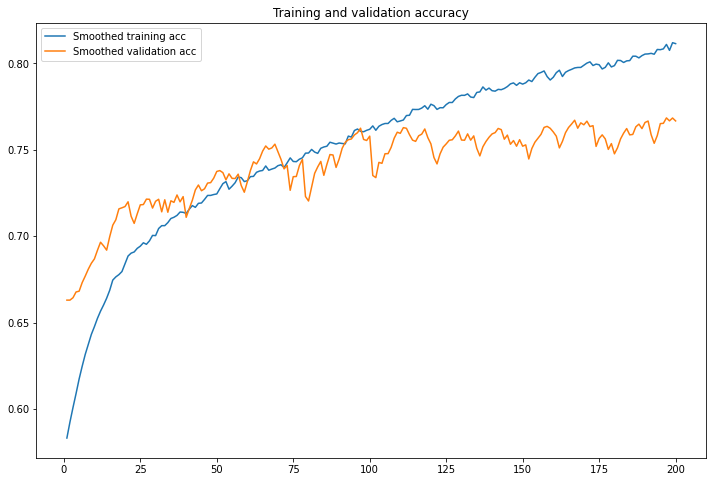

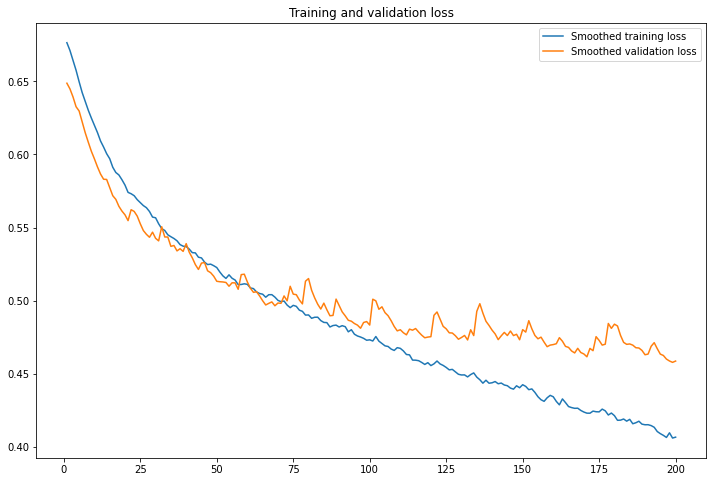

In [83]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.figure(figsize=(12,8))
plt.plot(epochs, smooth_curve(acc), label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(epochs, smooth_curve(loss), label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [84]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = train_datagen.flow_from_dataframe(
    test, # Referimos el df de train
    directory=data_dir, # El directorio donde se encuentran las imágenes
    x_col='image', # La columna con los path de los archivos
    y_col='Diabetes', # La variable con las labels
    target_size=(res_x, res_y),
    classes=None, # Las clases se obtienen a partir de y_col
    class_mode='binary', # Se trata de un problema multi-class, multi-label
    batch_size=20
   )

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Accuracy en test:', test_acc)
print('Loss en test:', test_loss)

Found 1863 validated image filenames belonging to 2 classes.
Accuracy en test: 0.7379999756813049
Loss en test: 0.497877836227417
